In [131]:
import requests
def obtainDay_data(symbol, fileExport):    
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+symbol+'&outputsize=full&apikey=FUU1SOYI000781S9'
    r = requests.get(url)
    data = r.json()

    rawData = pd.DataFrame(data)
    rawData.to_csv(fileExport, sep=',')

    rawData=rawData[7:]

    priceandvolume=pd.DataFrame()

    priceandvolume['High']=[d.get('2. high') for d in rawData['Time Series (Daily)']]
    priceandvolume['Low']=[d.get('3. low') for d in rawData['Time Series (Daily)']]
    priceandvolume['Close']=[d.get('4. close') for d in rawData['Time Series (Daily)']]
    priceandvolume['Volume']=[d.get('5. volume') for d in rawData['Time Series (Daily)']]

    priceandvolume.to_csv('Data'+symbol+'daily'+'.csv', sep=';', index=False)



In [142]:
symbol='MSFT'
obtainDay_data(symbol, "MSFT_daily")
### porque da error??

In [88]:
'''
#url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+symbol+'&outputsize=full&apikey=FUU1SOYI000781S9'
r = requests.get(url)
data = r.json()

fileExport="WTI_daily"

rawData = pd.DataFrame(data)
rawData.to_csv(fileExport, sep=',')
    
rawData=rawData[7:]
    
priceandvolume=pd.DataFrame()

priceandvolume['High']=[d.get('2. high') for d in rawData['Time Series (Daily)']]
priceandvolume['Low']=[d.get('3. low') for d in rawData['Time Series (Daily)']]
priceandvolume['Close']=[d.get('4. close') for d in rawData['Time Series (Daily)']]
priceandvolume['Volume']=[d.get('5. volume') for d in rawData['Time Series (Daily)']]

priceandvolume.to_csv('Data'+symbol+'daily'+'.csv', sep=';', index=False)
'''


'\n#url = \'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=\'+symbol+\'&outputsize=full&apikey=FUU1SOYI000781S9\'\nr = requests.get(url)\ndata = r.json()\n\nfileExport="WTI_daily"\n\nrawData = pd.DataFrame(data)\nrawData.to_csv(fileExport, sep=\',\')\n    \nrawData=rawData[7:]\n    \npriceandvolume=pd.DataFrame()\n\npriceandvolume[\'High\']=[d.get(\'2. high\') for d in rawData[\'Time Series (Daily)\']]\npriceandvolume[\'Low\']=[d.get(\'3. low\') for d in rawData[\'Time Series (Daily)\']]\npriceandvolume[\'Close\']=[d.get(\'4. close\') for d in rawData[\'Time Series (Daily)\']]\npriceandvolume[\'Volume\']=[d.get(\'5. volume\') for d in rawData[\'Time Series (Daily)\']]\n\npriceandvolume.to_csv(\'Data\'+symbol+\'daily\'+\'.csv\', sep=\';\', index=False)\n'

In [1]:
## importar librerias
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
import matplotlib.pyplot as plt

print("librerias cargadas")

librerias cargadas


In [2]:
csv_file="DataWTI.csv"
file = pd.read_csv('./DataWTIdaily.csv',sep=';')
#file = pd.read_csv('./DataMSFTdaily.csv',sep=';')
df1 = file.head(150000)
#df1.columns
df1.keys()

Index(['High', 'Low', 'Close', 'Volume'], dtype='object')

### nuestra idea es crear etiquetas para el entrenamiento, siguiento la logica de un trader 
logica trader -> mantener riesgo acotado, asi que la mayoria de estrategias 
suelen tener un limite de perdidad o "stop loss" y una ganancia esperada "take profit"
seran el stop loss y el take profit lo que usaremos para determinar las etiquetas o "labels"
que usara nuestra maquina para entrenar

Definicion de la etiquita: si hubieramos abierto una posicion en compra/venta, hubieramos acertado?

In [3]:
## vamos a crear las etiquetas

# tp_st_rel = proporcion ganancia esperada, perdida asumible = 2
tp_st_rel = 3

# desplazamiento esperado del mercado, 
m_esp = 1
#se espera que el mercado llegue a (precio_actual + m_esp*tp_st_rel) 
# si el precio llega a (precio_actual - m_esp) lo daremos como fallo


## vamos a mirar las posiciones siguientes para determinar si hubieramos acertado o no

price_up = np.array(df1['High'])
price_low = np.array(df1['Low'])
price_close = np.array(df1['Close'])

# si buscamos señales compra +1, si buscamos señales venta -1
buy_or_sell = +1 # -1
etiquetas = []

In [4]:
etiquetas = []
for index,row in df1.iterrows():
    #print(index)
    price_actual = row['Close']
    #print(price_actual)
    for index_2,row2 in df1[(index+1):].iterrows():
        if buy_or_sell==1:
            #print(index,index_2)
            if row2['High'] > (price_actual+m_esp*tp_st_rel) and row2['Low'] < (price_actual-m_esp):
                label = 0 #None 
                #print("111111")
                #existe la posibiliad
                etiquetas.append(label)
                #continue
                break
            elif row2['High'] > (price_actual+m_esp*tp_st_rel):
                label = 1
                etiquetas.append(label)
                #continue
                break
            elif row2['Low'] < (price_actual-m_esp):
                label = 0
                etiquetas.append(label)
                #continue
                break
            # ultima data no tendra etiquetas
        if index_2 == len(df1['Low'])-1:
            label = 0 #None
            etiquetas.append(label)
                
etiquetas = np.array(etiquetas)
len(etiquetas)

4712

In [5]:
#etiquetas 

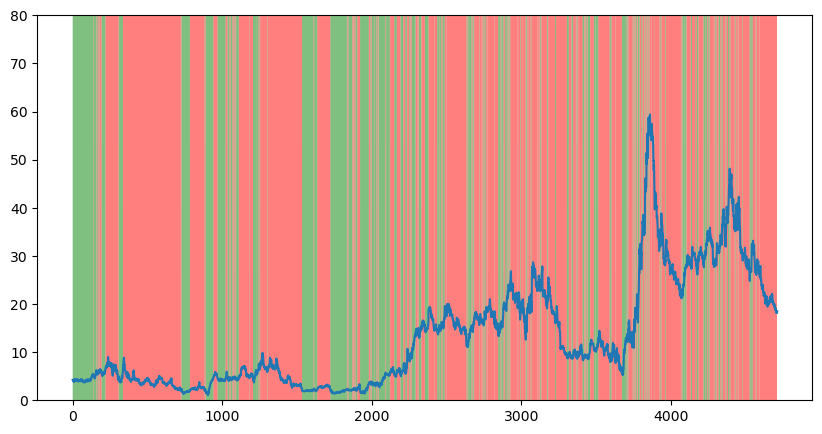

In [6]:
fig, ax = plt.subplots( figsize=(10, 5))
ax.plot(price_close)
#ax.plot(etiquetas,"-")
import matplotlib.transforms as mtransforms
x = np.array(range(0, len(etiquetas), 1))
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
tras = False
#trans =ax.get_xaxis_transform()
''' 
ax.fill_between(x, 9*np.ones(len(x)), 13*np.ones(len(x)), where=etiquetas > 9.6 ,
                facecolor='green', alpha=0.5,interpolate=True)
ax.fill_between(x, 9*np.ones(len(x)), 13*np.ones(len(x)), where=etiquetas < 9.5,
                facecolor='red', alpha=0.5,interpolate=True)
ax.fill_between(x, 9*np.ones(len(x)), 13*np.ones(len(x)), where=etiquetas == 9.6 ,
                facecolor='orange', alpha=0.5,interpolate=True)
ax.fill_between(x, 9*np.ones(len(x)), 13*np.ones(len(x)), where=etiquetas == 9.5,
                facecolor='orange', alpha=0.5,interpolate=True)
'''
ax.fill_between(x, 0, 15, where=etiquetas > 0.6 ,
                facecolor='green', alpha=0.5,interpolate=True, transform=trans)
ax.fill_between(x, 0, 15, where=etiquetas < 0.5,
                facecolor='red', alpha=0.5,interpolate=True, transform=trans)
ax.fill_between(x, 0, 15, where=etiquetas == 9.6 ,
                facecolor='orange', alpha=0.5,interpolate=True, transform=trans)
ax.fill_between(x, 0, 15, where=etiquetas == 9.5,
                facecolor='black', alpha=0.5,interpolate=True, transform=trans)
#'''
#ax.set_xlim([xmin, xmax])
ax.set_ylim([0, 80])
plt.show()

## Los datos no tendran vida pero igual necesitan algo de amor <3

## Es momento de preparar la data!

### ¿Porque?: 
Los algoritmos sueles funcionar mejor cuando los datos estan normalizados y no tienen valores demasiado alejados entre si.
Es decir, si tuvieras por ejemplo como entrada en la red neuronal el valor del precio 4000 y el indicador RSI que esta en el intervalo 0 a 1 entonces el algoritmo no funcionara bien.

In [7]:
## temporalidades usadas para mies indicadores
SMA_TEMP1 = 14
SMA_TEMP2 = 25
std_temp_1 = 14
num_temp = 8

SMA_1_array = []
SMA_2_array = []
std_1_array = []
MACD_1_array = []

opcionA = True


max_time = np.max([SMA_TEMP1,SMA_TEMP2,std_temp_1,num_temp])


#for idx,row in df1.iterrows():
for idx in range(max_time,len(df1)):   
        
    if opcionA:
        SMA_1 = np.mean(df1['Close'][(idx-SMA_TEMP1):(idx)]) - df1['Close'][idx]
        SMA_2 = np.mean(df1['Close'][(idx-SMA_TEMP2):(idx)]) - df1['Close'][idx]
    else:
        SMA_1 = np.mean(df1['Close'][(idx-SMA_TEMP1):(idx)]) - np.mean(df1['Close'][(idx-SMA_TEMP2-1):(idx-1)])
        SMA_2 = np.mean(df1['Close'][(idx-SMA_TEMP2):(idx)]) - np.mean(df1['Close'][(idx-SMA_TEMP2-1):(idx-1)])
    
    std_1 = np.std(df1['Close'][(idx-std_temp_1):(idx)])#[idx:(idx+std_temp_1)])
    MACD_1 = (0.15*df1['Close'][idx] + 0.85*SMA_1) - (0.075*df1['Close'][idx] + 0.925*SMA_2)

    SMA_1_array.append(SMA_1)
    SMA_2_array.append(SMA_2)
    std_1_array.append(std_1)
    MACD_1_array.append(MACD_1)
    
data_close = df1['Close'][max_time:]
etiquetas = etiquetas[(max_time-1):]
#print(MACD_1_array)

In [8]:
print("dataset len:",len(df1))
print("data_close len:",len(data_close))
print("etiquetas len:",len(etiquetas))
print("SMA len:",len(SMA_2_array))

dataset len: 4713
data_close len: 4688
etiquetas len: 4688
SMA len: 4688


Se realizara una normalizacion de los datos para aumentar la estabilidad de la red, esto significa que a cad conjunto de datos se le restara el promedio y se dividira por la desviacion estandar. 

In [9]:
def Normalization_vec(vec):
    vec = ( vec - np.mean(vec) ) / np.std(vec)  
    return vec

SMA_1_array = Normalization_vec(SMA_1_array)
SMA_2_array = Normalization_vec(SMA_2_array)
std_1_array = Normalization_vec(std_1_array)
MACD_1_array = Normalization_vec(MACD_1_array)


## creacion del dicconario conteniendo las entradas que usaremos en las redes neuronales

Dictionary_data ={
    "0": SMA_1_array,
    "1": SMA_2_array,
    "2": std_1_array,
    "3": MACD_1_array,
    "data_close": data_close,
    "label": etiquetas
}

In [10]:
class MyDataSet_train(torch.utils.data.Dataset):
    def __init__(self, Dictionary_data, initial_dic):
        #self.filename = filename
        self.EM14 = 1
        self.max_time = max_time
        #self.num_serie = 10
        
    def __len__(self):
        return len(Dictionary_data["1"]) - self.max_time
    
    def __getitem__(self, idx):

        features = []
        
        for i in range (0,len(Dictionary_data)-2):
            features.append(Dictionary_data[str(i)][idx])  
        
        idx_aux = idx+max_time
        data_serie = df1['Close'][(idx_aux-num_temp):(idx_aux)]
        data_serie = np.array(data_serie,dtype="float32" )
        data_serie = data_serie - df1['Close'][(idx_aux-num_temp)]
        data_serie = data_serie[1:]
        
        if idx<25:
            print("idx_aux->",idx_aux,"   ","idx->",idx)
            print("........",data_serie)
        
        #for i in range (0,len(Dictionary_data)-1):
        #    features.append(Dictionary_data[str(i)][idx])
        #    #print(len(features) )
            
        return np.array(features,dtype="float32" ), np.array( Dictionary_data["label"][idx],dtype="float32"), data_serie


In [11]:
Data_set = MyDataSet_train( Dictionary_data, df1 )
Batch_number = 128

size_train = 0.2

from sklearn.model_selection import train_test_split
Data_train,Data_test = train_test_split(Data_set, test_size = size_train )#, random_state = 14)


idx_aux-> 32     idx-> 7
........ [-0.11999989  0.10000038 -0.13999987  0.         -0.00999975  0.0800004
  0.03000021]
idx_aux-> 26     idx-> 1
........ [-0.02999973 -0.01999998  0.07999992  0.03999996  0.03999996  0.07999992
 -0.03999996]
idx_aux-> 46     idx-> 21
........ [0.11000013 0.21999979 0.27999973 0.3199997  0.23999977 0.0999999
 0.1500001 ]
idx_aux-> 41     idx-> 16
........ [ 0.03000021 -0.06999969 -0.08999991 -0.11999989 -0.17999983 -0.06999969
  0.03999996]
idx_aux-> 49     idx-> 24
........ [ 0.03999996 -0.03999996 -0.17999983 -0.12999964 -0.06999969 -0.05999994
 -0.13999987]
idx_aux-> 40     idx-> 15
........ [-0.30999994 -0.27999973 -0.37999964 -0.39999986 -0.42999983 -0.48999977
 -0.37999964]
idx_aux-> 31     idx-> 6
........ [ 0.03999996 -0.07999992  0.14000034 -0.0999999   0.03999996  0.03000021
  0.12000036]
idx_aux-> 29     idx-> 4
........ [-0.03999996 -0.03999996  0.         -0.11999989  0.10000038 -0.13999987
  0.        ]
idx_aux-> 34     idx-> 9
........ [-0

In [12]:
# Let's go to use an simple Neural Network :3 :3 :3

N_layer1 = 10
N_layer2 = 16
N_layer3 = 10

do_dropout = False
Drop_rate = 0.2

class NN_simple(nn.Module):
    def __init__(self):
        super(NN_simple,self).__init__()

        self.Drop = nn.Dropout( Drop_rate ) 
        
        self.layer1 = nn.Linear(len(Dictionary_data)-2 ,N_layer1)   
        self.layer2 = nn.Linear(N_layer1,N_layer2) 
        self.layer3 = nn.Linear(N_layer2,N_layer3) 
        self.layer4 = nn.Linear(N_layer3,1) 
        #self.layer5 = nn.Linear(N_layer4,1)  
        
        self.activationReLU = nn.ReLU()
        self.activationLeaky = nn.LeakyReLU()
        self.activation = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def  forward(self,x): 
        x = self.layer1(x)
        x = self.activationReLU(x)
        if do_dropout ==True:
            x = self.Drop(x)   ###!!!!!!!!!!!!
        
        x = self.layer2(x)
        x = self.activationReLU(x)
        if do_dropout ==True:
            x = self.Drop(x)   ###!!!!!!!!!!!!
        
        x = self.layer3(x)
        x = self.activationReLU(x)

        if do_dropout ==True:
            x = self.Drop(x)   ###!!!!!!!!!!!!
        
        x = self.layer4(x)

        x = nn.functional.sigmoid(x)

        return x

In [13]:
train_loader = DataLoader(Data_train,batch_size=Batch_number, shuffle=True)
test_loader = DataLoader(Data_test,batch_size=Batch_number, shuffle=True)

model = NN_simple()

learning_ratio = 0.002

optimizer = torch.optim.Adam(model.parameters(), lr=learning_ratio ) 
criterion = nn.CrossEntropyLoss()


#torch.nn.functional.binary_cross_entropy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [14]:
model.train()
epoch_loss=0
num_epochs= 12
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in train_loader:
        #data = data.to(device)
        model.train()
        
        optimizer.zero_grad()
        out = model(data[0])
        out = out.view(-1, out.shape[-1])
        
        #labels = torch.tensor(data.y, dtype=torch.long).to(device) 
        labels = data[1]
        #print(out.shape)
        labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
        
        loss = torch.nn.functional.binary_cross_entropy(out, labels)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        
        
        epoch_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_train: {epoch_loss:.4f}')

    
    epoch_loss = 0.0
    #model.eval()
    nodes_out = torch.tensor([])
    labels_test = torch.tensor([])
    if (epoch+1)%1==0:
        for data in test_loader:
            model.eval()
            #data = data.to(device)  # Move batch data to the same device as model
            out = model(data[0])
            out = out.view(-1, out.shape[-1])
            labels = data[1] 
            labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
            loss = torch.nn.functional.binary_cross_entropy(out, labels)
    
            nodes_out = torch.cat((nodes_out, out), 0)
            labels_test = torch.cat((labels_test, labels), 0)    
    
            epoch_loss += loss.item()
        #model.train()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss_test: {epoch_loss:.4f}')


Epoch [1/12], Loss_train: 21.4202
Epoch [1/12], Loss_test: 5.3956
Epoch [2/12], Loss_train: 19.1395
Epoch [2/12], Loss_test: 5.1462
Epoch [3/12], Loss_train: 18.4673
Epoch [3/12], Loss_test: 5.1407
Epoch [4/12], Loss_train: 18.4547
Epoch [4/12], Loss_test: 5.1063
Epoch [5/12], Loss_train: 18.2506
Epoch [5/12], Loss_test: 5.1308
Epoch [6/12], Loss_train: 18.1834
Epoch [6/12], Loss_test: 5.0889
Epoch [7/12], Loss_train: 18.2254
Epoch [7/12], Loss_test: 5.1597
Epoch [8/12], Loss_train: 18.1894
Epoch [8/12], Loss_test: 5.0948
Epoch [9/12], Loss_train: 18.2581
Epoch [9/12], Loss_test: 5.0927
Epoch [10/12], Loss_train: 18.2652
Epoch [10/12], Loss_test: 5.0704
Epoch [11/12], Loss_train: 18.1388
Epoch [11/12], Loss_test: 5.0324
Epoch [12/12], Loss_train: 18.1902
Epoch [12/12], Loss_test: 5.0631


In [15]:
epoch_loss = 0.0
model.eval()
nodes_out = torch.tensor([])
labels_test = torch.tensor([])
#for data in train_loader:
for data in test_loader:
    #data = data.to(device)  # Move batch data to the same device as model
    out = model(data[0])
    out = out.view(-1, out.shape[-1])
    labels = data[1] 
    labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
    loss = torch.nn.functional.binary_cross_entropy(out, labels)
    
    nodes_out = torch.cat((nodes_out.clone().detach(), out.clone().detach()), 0)
    labels_test = torch.cat((labels_test.clone().detach(), labels.clone().detach()), 0)    
    
    epoch_loss += loss.item()
model.train()


nodes_out = torch.squeeze(nodes_out)
labels_test = torch.squeeze(labels_test)

print(f'Epoch [{epoch+1}/{num_epochs}], Loss_test: {epoch_loss:.4f}')


Epoch [12/12], Loss_test: 5.0574


In [16]:
print("media score buena prediccion->",torch.mean(nodes_out[labels_test>0.5]), "\n" , "media score mala prediccion->",torch.mean(nodes_out[labels_test<0.5]))
print("------------------------------------------")
print("------------------------------------------")

print("cantidad original up->",len(labels_test[labels_test>0.5]), "\n" , "cantidad original down->",len(labels_test[labels_test<0.5]))
print("------------------------------------------")
Seleccion_NN = labels_test[nodes_out>0.25]
print("cantidad escogida up->",len(Seleccion_NN[Seleccion_NN>0.5]), "\n" , "cantidad escogida down->",len(Seleccion_NN[Seleccion_NN<0.5]))


media score buena prediccion-> tensor(0.3880) 
 media score mala prediccion-> tensor(0.3370)
------------------------------------------
------------------------------------------
cantidad original up-> 338 
 cantidad original down-> 595
------------------------------------------
cantidad escogida up-> 298 
 cantidad escogida down-> 446


In [17]:
Seleccion_NN = labels_test[nodes_out>0.45]

print("cantidad escogidas up->",len(Seleccion_NN[Seleccion_NN>0.5]), "\n" , "cantidad escogidas down->",len(Seleccion_NN[Seleccion_NN<0.5])) 


cantidad escogidas up-> 110 
 cantidad escogidas down-> 117


In [18]:
#labels_test[nodes_out>0.45]

## Funcionaaaaa!!!

### ¿Y ahora que?

Veamos ni se puede mejor el resultado :D :D



In [19]:
# Let's go to use an simple Neural Network :3 :3 :3

N_layer1 = 10
N_layer2 = 16
N_layer3 = 10

do_dropout = False
Drop_rate = 0.2

class NN_plus_LSTM(nn.Module):
    def __init__(self):
        super(NN_plus_LSTM,self).__init__()

        self.Drop = nn.Dropout( Drop_rate ) 
        
        self.layer1 = nn.Linear(len(Dictionary_data)-2 ,N_layer1)   
        self.layer2 = nn.Linear(N_layer1,N_layer2) 
        self.layer3 = nn.Linear(N_layer2+8,N_layer3) 
        self.layer4 = nn.Linear(N_layer3,1) 
        #self.layer5 = nn.Linear(N_layer4,1)  
        
        self.LSTM = nn.LSTM(input_size=8, hidden_size=64, num_layers=1, batch_first=True)
        #self.LSTM = nn.LSTM(input_size=1, hidden_dim=32, num_layers=1)
        #self.LSTM = nn.LSTM(1, 32, num_layers=1)
        # recuerda que num_temp esta definido arriba!
        # self.lstm = nn.LSTM(embedding_dim, hidden_dim) # ejemplo de pytorch
        self.LinearLayer_lstm = nn.Linear(64,8)
        
        self.activationReLU = nn.ReLU()
        self.activationLeaky = nn.LeakyReLU()
        self.activation = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1) 
        
    def  forward(self, x , serie_data):   
        
        #for i in range(0,len(serie_data)):
        #    print(serie_data[i])
        
        series_out, (a,b) = self.LSTM(serie_data)
        #print("000",series_out[0])

        series_out = self.LinearLayer_lstm(series_out)
        
        x = self.layer1(x)
        x = self.activationReLU(x)
        if do_dropout ==True:
            x = self.Drop(x)   ###!!!!!!!!!!!!
                
        x = self.layer2(x)
        x = self.activationReLU(x)
        if do_dropout ==True:
            x = self.Drop(x)   ###!!!!!!!!!!!!

        x = torch.cat(( x, series_out ), dim=1)

        #print("111",series_out)

        x = self.layer3(x)
        x = self.activationReLU(x)

        if do_dropout ==True:
            x = self.Drop(x)   ###!!!!!!!!!!!!
        
        x = self.layer4(x)

        x = nn.functional.sigmoid(x)
        
        #print("222",x)

        return x


In [20]:
model = NN_plus_LSTM()

learning_ratio = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_ratio ) 
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

NN_plus_LSTM(
  (Drop): Dropout(p=0.2, inplace=False)
  (layer1): Linear(in_features=4, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=16, bias=True)
  (layer3): Linear(in_features=24, out_features=10, bias=True)
  (layer4): Linear(in_features=10, out_features=1, bias=True)
  (LSTM): LSTM(8, 64, batch_first=True)
  (LinearLayer_lstm): Linear(in_features=64, out_features=8, bias=True)
  (activationReLU): ReLU()
  (activationLeaky): LeakyReLU(negative_slope=0.01)
  (activation): Sigmoid()
  (softmax): Softmax(dim=1)
)

In [21]:
model.train()
epoch_loss=0
num_epochs= 15
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in train_loader:
        #data = data.to(device)
        
        model.train()
        
        optimizer.zero_grad()
        #out = model(data[0])#,data[2])
        out = model(data[0],data[2])
        out = out.view(-1, out.shape[-1])
        
        #labels = torch.tensor(data.y, dtype=torch.long).to(device) 
        labels = data[1]
        #print(out.shape)
        labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
        
        loss = torch.nn.functional.binary_cross_entropy(out, labels)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        
        epoch_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_train: {epoch_loss:.4f}')

    
    epoch_loss = 0.0
    #model.eval()
    nodes_out = torch.tensor([])
    labels_test = torch.tensor([])
    if (epoch+1)%1==0:
        for data in test_loader:
            model.eval()
            #data = data.to(device)  # Move batch data to the same device as model
            #out = model(data[0])#,data[2])
            out = model(data[0],data[2])
            out = out.view(-1, out.shape[-1])
            labels = data[1] 
            labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
            loss = torch.nn.functional.binary_cross_entropy(out, labels)
    
            nodes_out = torch.cat((nodes_out, out), 0)
            labels_test = torch.cat((labels_test, labels), 0)    
    
            epoch_loss += loss.item()
        #model.train()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss_test: {epoch_loss:.4f}')


Epoch [1/15], Loss_train: 20.0520
Epoch [1/15], Loss_test: 5.1960
Epoch [2/15], Loss_train: 18.7335
Epoch [2/15], Loss_test: 5.1081
Epoch [3/15], Loss_train: 18.2062
Epoch [3/15], Loss_test: 5.0787
Epoch [4/15], Loss_train: 18.0863
Epoch [4/15], Loss_test: 5.0642
Epoch [5/15], Loss_train: 17.9557
Epoch [5/15], Loss_test: 5.1007
Epoch [6/15], Loss_train: 18.0812
Epoch [6/15], Loss_test: 4.9975
Epoch [7/15], Loss_train: 17.8147
Epoch [7/15], Loss_test: 5.1070
Epoch [8/15], Loss_train: 17.9602
Epoch [8/15], Loss_test: 4.9302
Epoch [9/15], Loss_train: 17.7478
Epoch [9/15], Loss_test: 5.0118
Epoch [10/15], Loss_train: 17.5548
Epoch [10/15], Loss_test: 4.9751
Epoch [11/15], Loss_train: 17.6250
Epoch [11/15], Loss_test: 5.0077
Epoch [12/15], Loss_train: 17.5505
Epoch [12/15], Loss_test: 5.0139
Epoch [13/15], Loss_train: 17.5471
Epoch [13/15], Loss_test: 4.9624
Epoch [14/15], Loss_train: 17.3419
Epoch [14/15], Loss_test: 4.9256
Epoch [15/15], Loss_train: 17.4984
Epoch [15/15], Loss_test: 4.891

In [22]:
epoch_loss = 0.0
model.eval()
nodes_out = torch.tensor([])
labels_test = torch.tensor([])
#for data in train_loader:
for data in test_loader:
    #data = data.to(device)  # Move batch data to the same device as model
    
    #out = model(data[0])#,data[2])
    out = model(data[0],data[2])
    out = out.view(-1, out.shape[-1])
    labels = data[1] 
    labels = torch.reshape(labels, (int(list(labels.shape)[0]),1))
    loss = torch.nn.functional.binary_cross_entropy(out, labels)
    
    nodes_out = torch.cat((nodes_out.clone().detach(), out.clone().detach()), 0)
    labels_test = torch.cat((labels_test.clone().detach(), labels.clone().detach()), 0)    
    
    epoch_loss += loss.item()
model.train()


nodes_out = torch.squeeze(nodes_out)
labels_test = torch.squeeze(labels_test)

print(f'Epoch [{epoch+1}/{num_epochs}], Loss_test: {epoch_loss:.4f}')


Epoch [15/15], Loss_test: 4.9797


In [23]:
print("media score buena prediccion->",torch.mean(nodes_out[labels_test>0.5]), "\n" , "media score mala prediccion->",torch.mean(nodes_out[labels_test<0.5]))
print("------------------------------------------")
print("------------------------------------------")

print("cantidad original up->",len(labels_test[labels_test>0.5]), "\n" , "cantidad original down->",len(labels_test[labels_test<0.5]))
print("------------------------------------------")
Seleccion_NN = labels_test[nodes_out>0.25]
print("cantidad escogida up->",len(Seleccion_NN[Seleccion_NN>0.5]), "\n" , "cantidad escogida down->",len(Seleccion_NN[Seleccion_NN<0.5]))


media score buena prediccion-> tensor(0.4289) 
 media score mala prediccion-> tensor(0.3346)
------------------------------------------
------------------------------------------
cantidad original up-> 338 
 cantidad original down-> 595
------------------------------------------
cantidad escogida up-> 291 
 cantidad escogida down-> 396


In [204]:
import requests
url = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=AAPL&apikey=demo'
r = requests.get(url)
data = r.json()

print(data.keys())

dict_keys(['items', 'sentiment_score_definition', 'relevance_score_definition', 'feed'])


In [205]:
print(data['feed'])

[{'title': 'Gaming Market size to grow by USD 102.13 billion from 2022 to 2027, Activision Blizzard Inc., Apple Inc., Bandai ... - PR Newswire', 'url': 'https://www.prnewswire.com/news-releases/gaming-market-size-to-grow-by-usd-102-13-billion-from-2022-to-2027--activision-blizzard-inc-apple-inc-bandai-namco-holdings-inc-bowlmor-amf-and-more-among-the-prominent-companies-in-the-market---technavio-301963195.html', 'time_published': '20231022T010000', 'authors': [], 'summary': 'Gaming Market size to grow by USD 102.13 billion from 2022 to 2027, Activision Blizzard Inc., Apple Inc., Bandai ... PR ...', 'banner_image': None, 'source': 'PR Newswire', 'category_within_source': 'n/a', 'source_domain': 'www.prnewswire.com', 'topics': [{'topic': 'Technology', 'relevance_score': '1.0'}], 'overall_sentiment_score': 0.251031, 'overall_sentiment_label': 'Somewhat-Bullish', 'ticker_sentiment': [{'ticker': 'MSFT', 'relevance_score': '0.05833', 'ticker_sentiment_score': '0.081979', 'ticker_sentiment_la

In [206]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=RETAIL_SALES&apikey=demo'
r = requests.get(url)
data = r.json()

print(data)

{'name': 'Advance Retail Sales: Retail Trade', 'interval': 'monthly', 'unit': 'millions of dollars', 'data': [{'date': '2023-09-01', 'value': '592660.0'}, {'date': '2023-08-01', 'value': '628892.0'}, {'date': '2023-07-01', 'value': '605403.0'}, {'date': '2023-06-01', 'value': '612243.0'}, {'date': '2023-05-01', 'value': '631496.0'}, {'date': '2023-04-01', 'value': '588220.0'}, {'date': '2023-03-01', 'value': '604084.0'}, {'date': '2023-02-01', 'value': '529374'}, {'date': '2023-01-01', 'value': '547156'}, {'date': '2022-12-01', 'value': '654825'}, {'date': '2022-11-01', 'value': '605205'}, {'date': '2022-10-01', 'value': '597170'}, {'date': '2022-09-01', 'value': '577966'}, {'date': '2022-08-01', 'value': '613508'}, {'date': '2022-07-01', 'value': '599929'}, {'date': '2022-06-01', 'value': '609743'}, {'date': '2022-05-01', 'value': '616626'}, {'date': '2022-04-01', 'value': '596690'}, {'date': '2022-03-01', 'value': '598541'}, {'date': '2022-02-01', 'value': '507901'}, {'date': '2022-0

In [207]:
Seleccion_Nodes

NameError: name 'Seleccion_Nodes' is not defined